## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [24]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [25]:
images_train, labels_train = next(iter(train_loader))

In [26]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

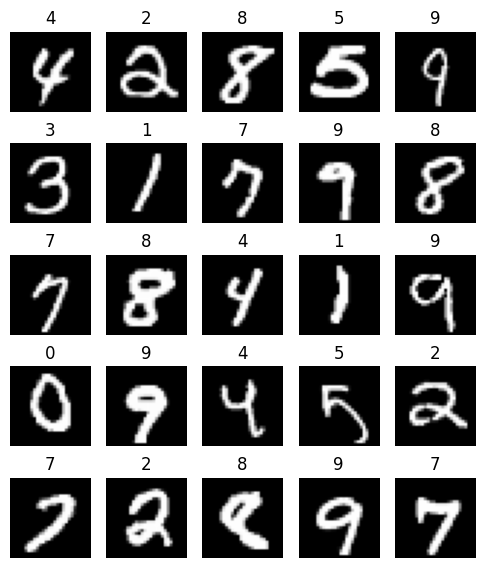

In [27]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [28]:
'''def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)'''

def init_layer(layer, mean=0, std=1):
    layer.weight.data.normal_(mean=mean, std=std)
    layer.bias.data.zero_()

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [29]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [30]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

In [31]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9883902668952942
forward 16.252199172973633
backward 0.02309400960803032
backward 0.18877099454402924


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

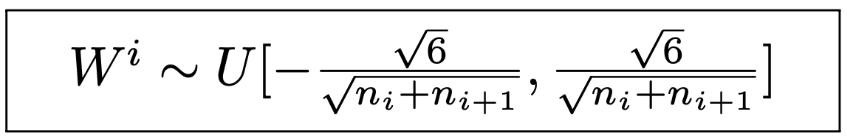

In [32]:
def init_layer(layer, n, n_next):
    layer.weight.data.uniform_(-np.sqrt(6 / (n + n_next)), np.sqrt(6 / (n + n_next)))
    layer.bias.data.zero_()

In [33]:
init_layer(layer_1, 28*28, 500)
init_layer(layer_2, 500, 10)

In [34]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9883902668952942
forward 0.6811234354972839
backward 0.02309400960803032
backward 0.012240290641784668


## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

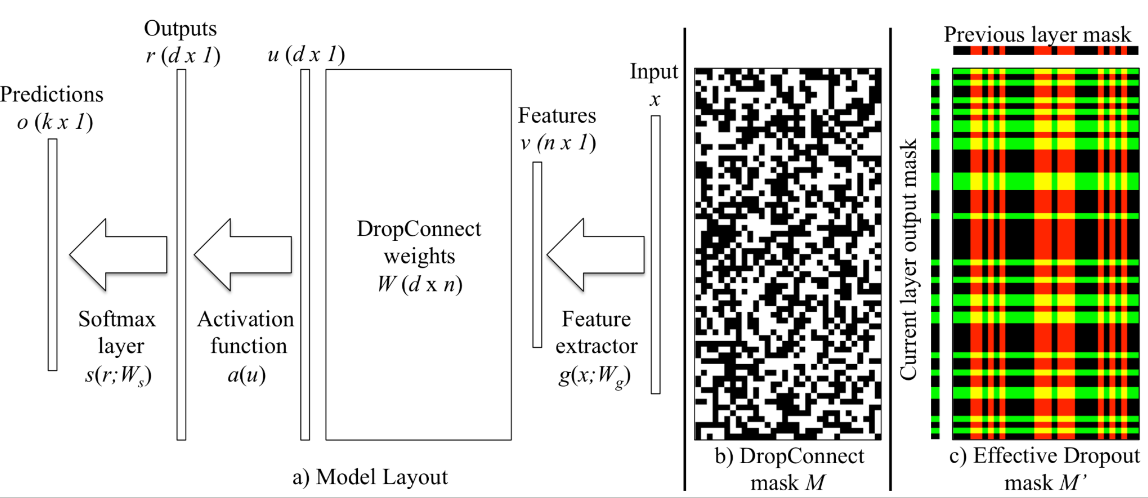

In [35]:
class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(self.linear.weight).bernoulli_(1 - self.p)
        else:
            mask = torch.full_like(self.linear.weight, 1 - self.p)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


Основа для сети, которую будем обучать:

In [75]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1), # 28x28
            nn.MaxPool2d(2), # 14x14
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1), # 14x14
            nn.MaxPool2d(2), # 7x7
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [88]:
layers = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [89]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [90]:
def train(network, optimezer, loss_fn, n_epoch=10):
    train_losses = []
    test_losses = []
    for epoch in range(n_epoch):
        network.train()

        train_batch_losses = []
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

            train_batch_losses.append(loss.item())

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        train_losses.append(np.mean(train_batch_losses))

        network.eval()
        test_batch_losses = []
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)

            test_batch_losses.append(loss.item())

        test_losses.append(np.mean(test_batch_losses))
        print('Test Epoch: {}\tLoss: {:.6f}'.format(
                epoch+1, np.mean(test_batch_losses)))

    return train_losses, test_losses

In [91]:
train_losses_dropconnect, test_losses_dropconnect = train(network, optimizer, loss_fn, n_epoch=15)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295406
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.005700
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.612726
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.422544
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.467133
Test Epoch: 1	Loss: 0.262621
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.232492
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.253210
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.209922
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.203226
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.153958
Test Epoch: 2	Loss: 0.155929
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.202569
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.216432
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.201907
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.219280
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.080425
Test Epoch: 3	Loss: 0.118382
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.195513
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.143409
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.189652
Train Epoch: 4 [38400/60000 (64%)

In [92]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.full_like(x, 1 - self.p)

        return x * mask

In [93]:
layers = [
    Dropout(),
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

Dropout стоит перед линейным слоем. Такой порядок больше всего близок к схеме с Dropconnect в предыдущем опыте.

In [94]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [95]:
train_losses_dropout, test_losses_dropout = train(network, optimizer, loss_fn, n_epoch=15)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303216
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.161545
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.844808
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.750437
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.507852
Test Epoch: 1	Loss: 0.261662
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.792583
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.433236
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.546107
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.462020
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.472909
Test Epoch: 2	Loss: 0.198816
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.551005
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.564706
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.416326
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.553683
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.486265
Test Epoch: 3	Loss: 0.170046
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.356471
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.498302
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.489410
Train Epoch: 4 [38400/60000 (64%)

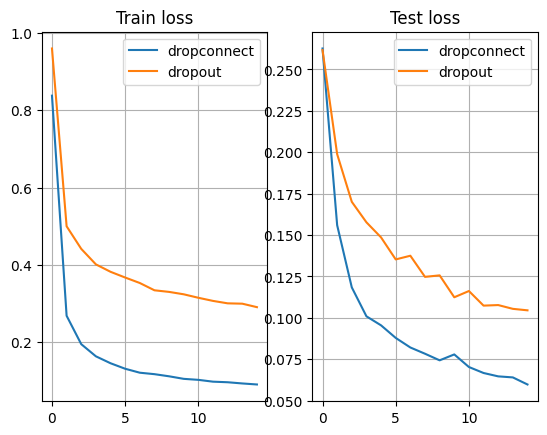

In [96]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(train_losses_dropconnect, label='dropconnect')
axs[0].plot(train_losses_dropout, label='dropout')
axs[0].set_title('Train loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(test_losses_dropconnect, label='dropconnect')
axs[1].plot(test_losses_dropout, label='dropout')
axs[1].set_title('Test loss')
axs[1].legend()
axs[1].grid()

plt.show()

Из графиков видно, что dropconnect сильно превосходит dropout. Однако занулять нейроны можно не только в линейных слоях, поэтому dropout можно расположить и после. Посмотрим, что из этого получится.

In [97]:
layers = [
    nn.Linear(196, 128),
    Dropout(),
    nn.ReLU(),
    nn.Linear(128, 128),
    Dropout(),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [98]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [99]:
train_losses_dropout_different, test_losses_dropout_different = train(network, optimizer, loss_fn, n_epoch=15)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304435
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.025628
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.526517
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.454574
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.470696
Test Epoch: 1	Loss: 0.228200
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.368948
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.434830
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.277677
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.247884
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.247558
Test Epoch: 2	Loss: 0.142230
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.236943
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.171161
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.223644
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.315863
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.217583
Test Epoch: 3	Loss: 0.110657
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.202647
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.164188
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.174453
Train Epoch: 4 [38400/60000 (64%)

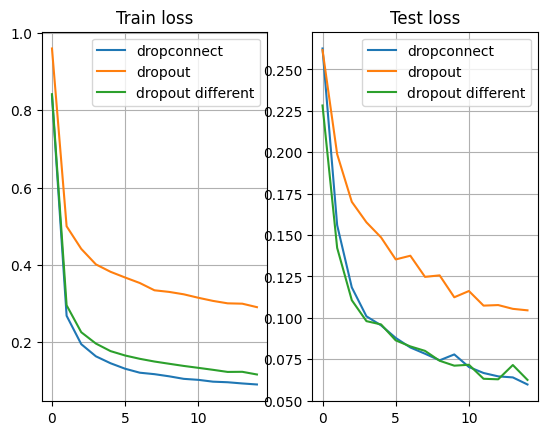

In [100]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(train_losses_dropconnect, label='dropconnect')
axs[0].plot(train_losses_dropout, label='dropout')
axs[0].plot(train_losses_dropout_different, label='dropout different')
axs[0].set_title('Train loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(test_losses_dropconnect, label='dropconnect')
axs[1].plot(test_losses_dropout, label='dropout')
axs[1].plot(test_losses_dropout_different, label='dropout different')
axs[1].set_title('Test loss')
axs[1].legend()
axs[1].grid()

plt.show()

При новом расположении последний dropout стоит перед последним линейным слоем и ReLU. Зануленные нейроны этим dropout остаются таковыми и после применения ReLU, и поступают на вход последнему линейному слою. Это означает, что при таком расположении dropout отключает нейроны последнего слоя, что, как правило, рекомендуется не делать. Однако, именно такая схема позволяет максимально приблизиться к результату dropconnect. Это немного контринтуитивно, но стоит признать, что такая схема dropout отрабатывает лучше.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

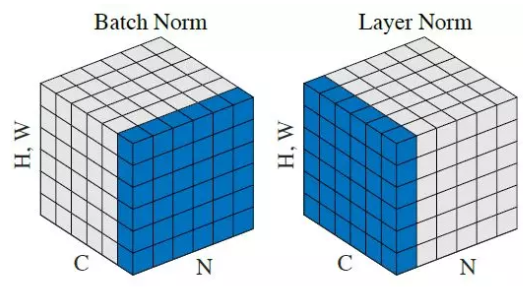

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [102]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-5)
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [103]:
layers = [
    LayerNormalization(),
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [104]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [105]:
train_losses_layernorm, test_losses_layernorm = train(network, optimizer, loss_fn, n_epoch=15)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.349374
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.225429
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.153071
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.083681
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.078366
Test Epoch: 1	Loss: 0.081970
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.100232
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.063758
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.101014
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.147835
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.029071
Test Epoch: 2	Loss: 0.067358
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.047957
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.064909
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.036099
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.054511
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.098657
Test Epoch: 3	Loss: 0.052077
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.013829
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.043601
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.025078
Train Epoch: 4 [38400/60000 (64%)

In [106]:
class BatchNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(dim=0, keepdim=True)) / (x.std(dim=0, keepdim=True) + 1e-5)
        return output

In [107]:
layers = [
    BatchNormalization(),
    nn.Linear(196, 128),
    nn.ReLU(),
    BatchNormalization(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [108]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [109]:
train_losses_batchnorm, test_losses_batchnorm = train(network, optimizer, loss_fn, n_epoch=15)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322763
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.353195
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.169335
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.125321
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.142638
Test Epoch: 1	Loss: 0.125718
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.090223
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.113142
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.136936
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.092533
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.076379
Test Epoch: 2	Loss: 0.095595
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.070281
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.060416
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.130254
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.056011
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.051437
Test Epoch: 3	Loss: 0.086229
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.022583
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.130423
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.064372
Train Epoch: 4 [38400/60000 (64%)

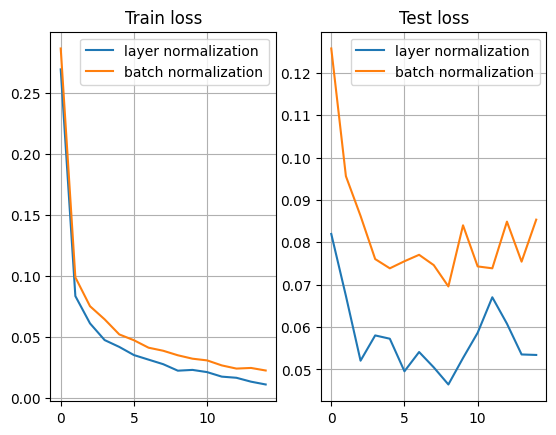

In [110]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(train_losses_layernorm, label='layer normalization')
axs[0].plot(train_losses_batchnorm, label='batch normalization')
axs[0].set_title('Train loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(test_losses_layernorm, label='layer normalization')
axs[1].plot(test_losses_batchnorm, label='batch normalization')
axs[1].set_title('Test loss')
axs[1].legend()
axs[1].grid()

plt.show()

Из графиков видно, что layer нормализация показывает себя лучше batch нормализации. Стоит отметить, что переобучение сети с выбранной архитектурой наступает гораздо быстрее при применении нормализации (2-3 эпоха), чем при регуляризации dropout или dropconnect (переобучение не наступило даже к 15 эпохе). Попробуем аналогично опытам с dropout поменять расположение слоев нормализации.

In [111]:
layers = [
    nn.Linear(196, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [112]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [113]:
train_losses_layernorm_different, test_losses_layernorm_different = train(network, optimizer, loss_fn, n_epoch=15)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.382129
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.340713
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.175520
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.167240
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.184133
Test Epoch: 1	Loss: 0.139904
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.189844
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.067051
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.085723
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.063448
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.085389
Test Epoch: 2	Loss: 0.098457
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.069863
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.117470
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.127187
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.174035
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.108893
Test Epoch: 3	Loss: 0.075733
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.033815
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.043936
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.128372
Train Epoch: 4 [38400/60000 (64%)

In [114]:
layers = [
    nn.Linear(196, 128),
    BatchNormalization(),
    nn.ReLU(),
    nn.Linear(128, 128),
    BatchNormalization(),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [115]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [116]:
train_losses_batchnorm_different, test_losses_batchnorm_different = train(network, optimizer, loss_fn, n_epoch=15)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.379949
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.328759
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.149645
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.258480
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.137529
Test Epoch: 1	Loss: 0.121905
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.087595
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.148975
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.084702
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.125803
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.140861
Test Epoch: 2	Loss: 0.087443
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.132254
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.082706
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.055559
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.085184
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.081697
Test Epoch: 3	Loss: 0.082167
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019258
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.023374
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.053667
Train Epoch: 4 [38400/60000 (64%)

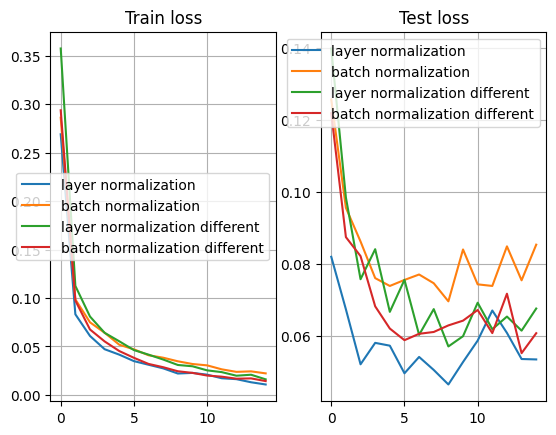

In [117]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(train_losses_layernorm, label='layer normalization')
axs[0].plot(train_losses_batchnorm, label='batch normalization')
axs[0].plot(train_losses_layernorm_different, label='layer normalization different')
axs[0].plot(train_losses_batchnorm_different, label='batch normalization different')
axs[0].set_title('Train loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(test_losses_layernorm, label='layer normalization')
axs[1].plot(test_losses_batchnorm, label='batch normalization')
axs[1].plot(test_losses_layernorm_different, label='layer normalization different')
axs[1].plot(test_losses_batchnorm_different, label='batch normalization different')
axs[1].set_title('Test loss')
axs[1].legend()
axs[1].grid()

plt.show()

Новое расположение слоя нормализации положительно сказалось на batch norm и отрицательно на layer norm. Самым эффективным способом нормализации осталась layer нормализация перед линейными слоями.

**Выводы:**

-  Xavier инициализация значительно уменьшает разброс значений нейронов (forward pass) и их градиентов (backward pass).
-  Dropconnect показал себя лучше чем Dropout. Однако, экспериментирование с расположением Dropout имеет смысл, и может неожиданно улучшить результат.
-  Самым удачным типом нормализации оказался layer norm перед линейными слоями.
-  Если сравнивать нормализацию и регуляризацию, то наименьший loss был зафиксирован при layer нормализации (~0.05 уже на второй эпохе обучения), в то время как Dropconnect позволил получить loss ~0.06 только на пятнадцатой эпохе. Однако, после 2-3 эпохи при использовании нормализации началось явное переобучение сети, а в случае с Dropout и Dropconnect переобучение на наблюдалось даже на 15. Поэтому кажется, что использование Dropout и Dropconnect регуляризации более перспективный подход, но для раскрытия его потенциала требуется большое число эпох, в то время как нормализация дает хороший результат достаточно быстро.